In [1]:
import tensorflow as tf
from functionsTF import *
from functions import *
from IO import *

%load_ext autoreload
%autoreload 2

import time
import numpy as np
import matplotlib
%matplotlib inline
import pylab as plt
import seaborn as sns
#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

In [2]:
import mutual_info

In [3]:
N = 400
T = 4000

DEVICE = '/cpu:0'

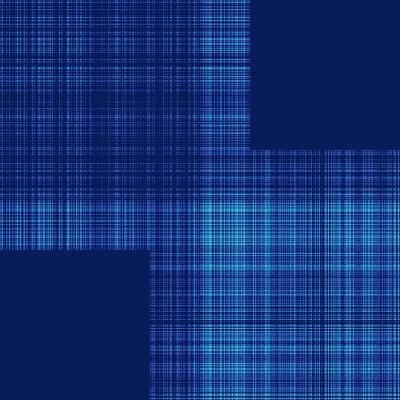

In [ ]:
disp = True
tauv = 45
sG = 50
N = N
both=False

### input 1: apple
gpu = Tfnet(N=N,T=T, disp=disp, tauv=tauv, sG=sG, device=DEVICE, both=both)
np.random.seed(2)
# apple = np.random.randint(0, 2, size=(T,1), dtype='int32')
apple = generateInput(3, T)
gpu.input = apple
gpu.both = True
gpu.runTFSimul()
apple_out = gpu.vvm[-1000:]

In [24]:
# plt.plot(gpu.vvmN1)
# plt.plot(gpu.vvmN2)
print(mutual_info.mutual_information_2d((gpu.vvmN1), (gpu.vvmN2)))
print(np.corrcoef(gpu.vvmN1,gpu.vvmN2)[0,1])

0.208372067942
0.0876210766374


In [5]:
for T in [4000, 8000, 60000]:
    for both in [True, False]:
        for N in [400]:
            for sG in [0,10,20,50]:
                for tauv in np.arange(15,95,5):
                    ### input 1: apple
                    disp=False
                    gpu = Tfnet(N=N,T=T, disp=disp, tauv=tauv, sG=sG, device=DEVICE, both=both, spikeMonitor=False)
                    np.random.seed(2)
                    apple = np.random.randint(0, 2, size=(T,1), dtype='int32')
                    gpu.input = apple
                    gpu.runTFSimul()
                    apple_out = gpu.vvm[-1000:]

                    filename = "mut_info_both-%s_tauv-%d_sg-%d_N-%d_input-%s_T=%d" % (str(both), tauv,sG, N, 'test', T)
                    with open(filename, 'wb') as f:
                        np.savez(f,vvmN1 = gpu.vvmN1, vvmN2 = gpu.vvmN2, 
                                cor1 = np.corrcoef(gpu.vvmN1[100:1100], gpu.vvmN2[100:1100])[0,1], 
                                cor2 = np.corrcoef(gpu.vvmN1[-1001:-1], gpu.vvmN2[-1001:-1])[0,1],
                                mutual_info.mutual_information_2d((gpu.vvmN1[100:1100]), (gpu.vvmN2[100:1100])),
                                mutual_info.mutual_information_2d((gpu.vvmN1[-1001:-1]), (gpu.vvmN2[-1001:-1]))
                                )

In [32]:
df = pd.DataFrame(columns=('tauv', 'sG', 'both', 'T', 'N', 'cor1', 'cor2','corChange', 'm1', 'm2', 'mChange') )
i=-1
for T in [4000, 8000, 60000]:
    for both in [True, False]:
        for N in [400]:
            for sG in [0,10,20,50]:
                for tauv in np.arange(15,95,5):
                    i+=1
                    filename = "both-%s_tauv-%d_sg-%d_N-%d_input-%s_T=%d" % (str(both), tauv,sG, N, 'test', T)
                    a = np.load(filename)
                    cor1 = np.corrcoef(a['vvmN1'][100:1100], a['vvmN2'][100:1100])[0,1]
                    cor2 = np.corrcoef(a['vvmN1'][T-1000:T], a['vvmN2'][T-1000:T])[0,1]
                    corChange = cor2/cor1
                    m1 = float(mutual_info.mutual_information_2d((a['vvmN1'][100:1100]), (a['vvmN2'][100:1100])))
                    m2 = float(mutual_info.mutual_information_2d((a['vvmN1'][-1001:-1]), (a['vvmN2'][-1001:-1])))
                    mChange = m2/m1
#                     df.loc[i] = [int(tauv), int(sG), bool(both), int(T), int(N), float(a['cor1']), float(a['cor2']) ]
                    df.loc[i] = [int(tauv), int(sG), bool(both), int(T), int(N), cor1, cor2, corChange, m1, m2, mChange ]

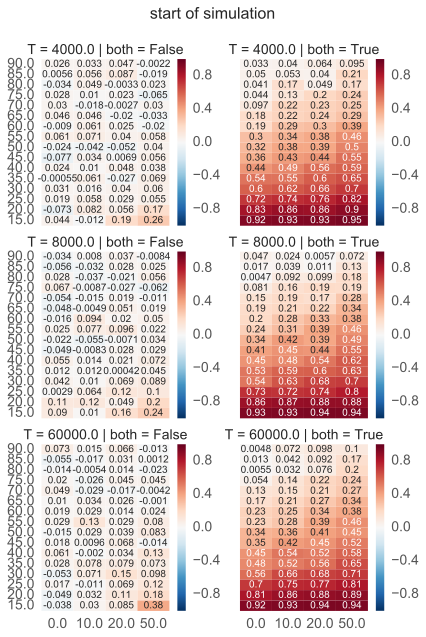

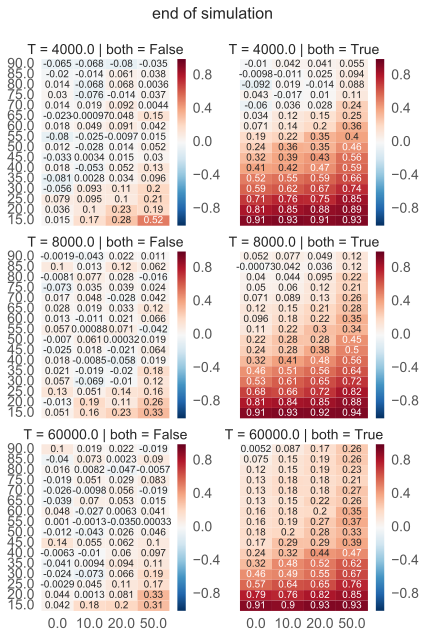

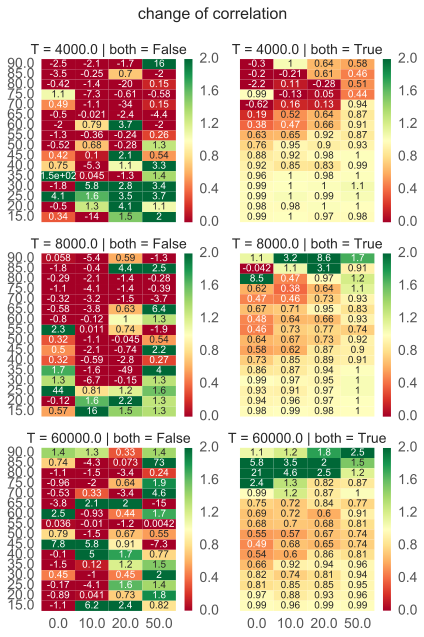

In [26]:
def facet_heatmap(data, col='cor1', **kws):
    cols = ['cor1', 'cor2', 'corChange']
#     data = pd.melt(df, id_vars=['tauv', 'sG'], value_vars=cols)
    data = data[data['variable']==col]
    data = data.pivot(index='tauv', columns='sG', values='value')
    im = sns.heatmap(data, annot=True, **kws) 
    im.invert_yaxis()
    

def plotGrid(df, col, title='', **kws):
    cols = ['cor1', 'cor2', 'corChange']
    data = pd.melt(df, id_vars=['tauv', 'sG', 'T', 'both'], value_vars=cols)

    with sns.plotting_context(font_scale=5.5):
        g = sns.FacetGrid(data, col="both",  row="T")
    g = g.map_dataframe(facet_heatmap, col=col, **kws)
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(title, fontsize='16')
    g.savefig(DIRECTORY + 'cor-plot_%s.png'%col)

plotGrid(df, 'cor1', 'start of simulation', cmap="RdBu_r", vmin=-0.1, vmax=1.0)
plotGrid(df, 'cor2', 'end of simulation', cmap="RdBu_r", vmin=-.1, vmax=1.0)
plotGrid(df, 'corChange', 'change of correlation',  cmap="RdYlGn", norm=MidpointNormalize(midpoint=1.), vmin=0, vmax=2)




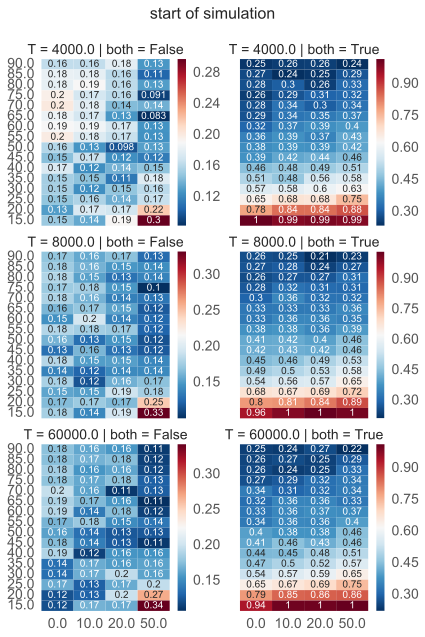

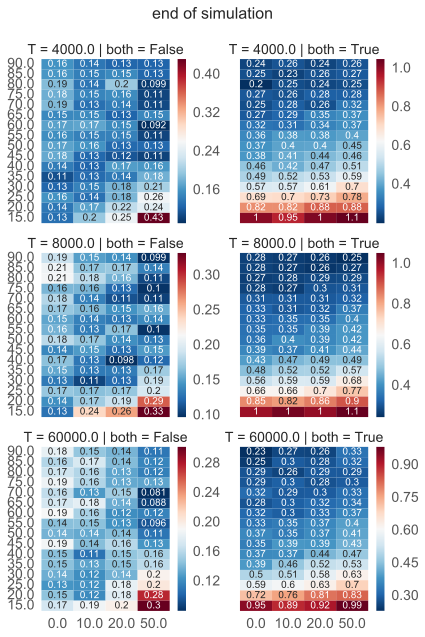

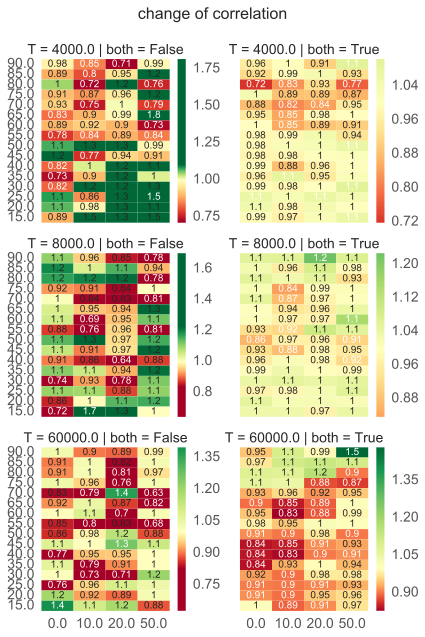

In [34]:
def facet_heatmap(data, col='cor1',cols = ['cor1', 'cor2', 'corChange'], **kws):
#     data = pd.melt(df, id_vars=['tauv', 'sG'], value_vars=cols)
    data = data[data['variable']==col]
    data = data.pivot(index='tauv', columns='sG', values='value')
    im = sns.heatmap(data, annot=True, **kws) 
    im.invert_yaxis()
    

def plotGrid(df, col, title='', cols = ['cor1', 'cor2', 'corChange'], **kws):
    data = pd.melt(df, id_vars=['tauv', 'sG', 'T', 'both'], value_vars=cols)

    with sns.plotting_context(font_scale=5.5):
        g = sns.FacetGrid(data, col="both",  row="T")
    g = g.map_dataframe(facet_heatmap, col=col, cols=cols, **kws)
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(title, fontsize='16')
    g.savefig(DIRECTORY + 'cor-plot_%s.png'%col)

plotGrid(df, 'm1', 'start of simulation', cmap="RdBu_r", cols = ['m1', 'm2', 'mChange'])
plotGrid(df, 'm2', 'end of simulation', cmap="RdBu_r", cols = ['m1', 'm2', 'mChange'])
plotGrid(df, 'mChange', 'change of correlation',  cmap="RdYlGn", 
         norm=MidpointNormalize(midpoint=1.), cols = ['m1', 'm2', 'mChange'])




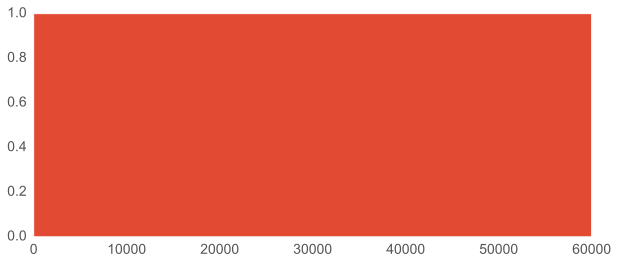

In [35]:
np.random.seed(2)
apple = np.random.randint(0, 2, size=(T,1), dtype='int32')
plt.plot(apple)

/Users/GP1514/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


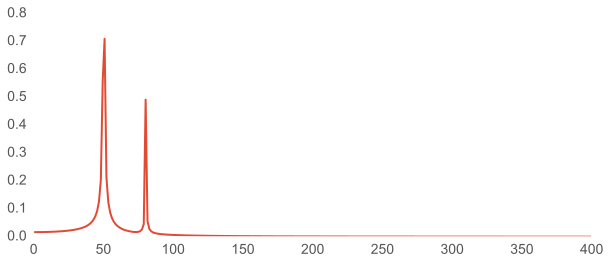

In [91]:
from scipy.fftpack import fft
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
plt.plot(xf, 2.0/N * np.abs(yf[0:N/2]))
plt.grid()
plt.show()

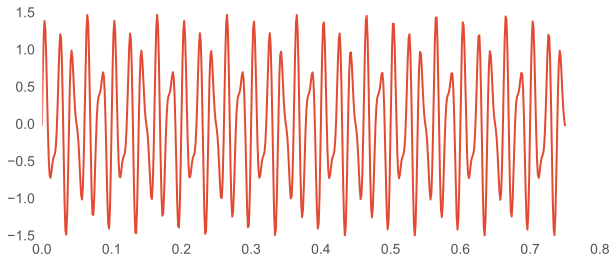

In [92]:
plt.plot(x, y)

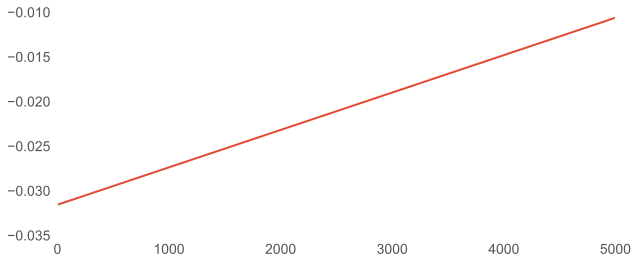

In [84]:
plt.plot(y[:5000])

/Users/GP1514/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


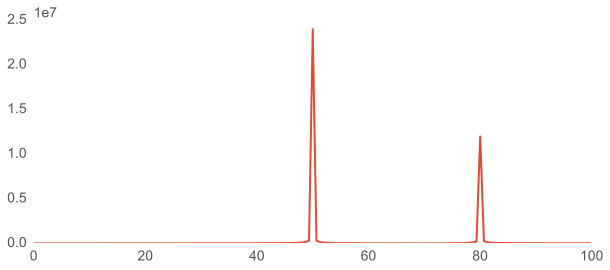

In [102]:
T  = 6000
# sample spacing
dt = 0.00025
x = np.linspace(0.0, dt*T, T)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*dt), T/2)
plt.plot(xf, 2.0/dt * np.abs(yf[0:T/2]))
plt.xlim([0,100])
plt.grid()
plt.show()

In [155]:
def generateInput(seed, T):
    dt = 0.00025
    np.random.seed(seed)
    x = np.linspace(0.0, dt*T, T)
    y = np.zeros(len(x))
    for i in range(5,100,5):
        y += np.random.rand()*np.sin(i * 2.0*np.pi*x)
    return y/np.max(y)

def plotFFT(y, T):
    dt = 0.00025
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*dt), T/2)
    plt.figure()
    plt.plot(xf, 2.0/dt * np.abs(yf[0:T/2]))
    plt.xlim([0,150])
    

/Users/GP1514/.pyenv/versions/anaconda3-2.5.0/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


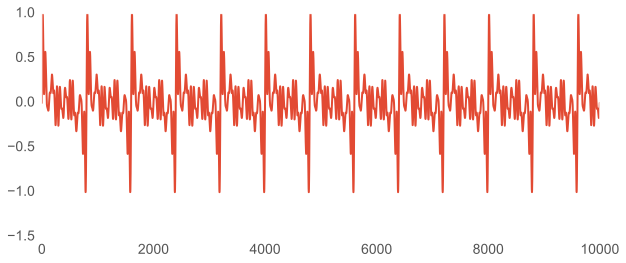

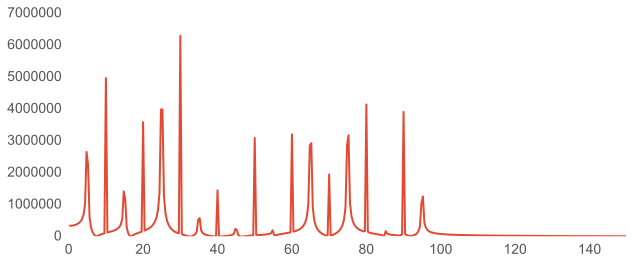

In [156]:
T = 10000
apple = generateInput(3, T)
plt.plot(apple)
plotFFT(apple, T)